# <font color='blue'>Imports </font>

In [1]:
%%time
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm
import optuna
import optuna.integration.lightgbm as lgb
import matplotlib.lines as line
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rc
import sklearn.datasets as skd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss, brier_score_loss

Wall time: 2.12 s


In [2]:
path = 'D:\\Python\\Notebooks\\Datascience\\Classification_datascience\\webscrapping\\matches\\rounds\\'
dataset = pd.read_csv('{}combined_csv.csv'.format(path))

In [7]:
#dataset = dataset.drop(['bestOF', 'RoundNumber', 'SeriesID', 'MatchID', 'RoundID', 'RoundTime'], axis=1)
dataset = dataset[["ATK_wealth", "DEF_wealth", "ATK_alive", "DEF_alive", "DEF_has_OP", "Def_has_Odin",
                    "RegularTime", "SpikeTime", "MapName", "FinalWinner"]]

In [8]:
dataset = pd.get_dummies(dataset, columns=['MapName'])

In [9]:
dataset.head()

,ATK_wealth,DEF_wealth,ATK_alive,DEF_alive,DEF_has_OP,Def_has_Odin,RegularTime,SpikeTime,FinalWinner,MapName_Ascent,MapName_Bind,MapName_Breeze,MapName_Haven,MapName_Icebox,MapName_Split
0,500.0,0.0,5,5,0,0,0,0,0,0,0,0,1,0,0
1,500.0,0.0,5,4,0,0,21,0,0,0,0,0,1,0,0
2,400.0,0.0,4,4,0,0,22,0,0,0,0,0,1,0,0
3,300.0,0.0,3,4,0,0,24,0,0,0,0,0,1,0,0
4,200.0,0.0,2,4,0,0,26,0,0,0,0,0,1,0,0


In [10]:
X = dataset.drop(['FinalWinner'], axis='columns')
Y = dataset.FinalWinner

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=15)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, train_size=0.9, test_size=0.1, random_state=15)

# <font color='blue'>Parameter tuning </font>

In [11]:
def objective(trial):
    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',2,100),
    max_depth = trial.suggest_int('max_depth',1,20),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.1),
    num_leaves = trial.suggest_int('num_leaves',2,70),
    num_threads = trial.suggest_int('num_threads',1,10),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,10),
    
    model = lightgbm.LGBMClassifier(bagging_freq=bagging_freq,
                                    min_data_in_leaf=min_data_in_leaf,
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   num_leaves=num_leaves,
                                   num_threads=num_threads,
                                   min_sum_hessian_in_leaf=min_sum_hessian_in_leaf)
    model.fit(X_train,Y_train)
    pred_proba_test = model.predict_proba(X_test)
    score = brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])
    return score

In [12]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2021-06-18 18:21:59,511] A new study created in memory with name: no-name-4afb57ad-215a-4836-99ef-51693f7fc1ea


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-18 18:22:00,357] Trial 0 finished with value: 0.15163679603689795 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 55, 'max_depth': 14, 'learning_rate': 0.008668521065884978, 'num_leaves': 60, 'num_threads': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 0 with value: 0.15163679603689795.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 18:22:00,728] Trial 1 finished with value: 0.14054632929522 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 51, 'max_depth': 3, 'learning_rate': 0.021124977232918906, 'num_leaves': 47, 'num_threads': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 1 with value: 0.14054632929522.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 18:22:01,097] Trial 2 finished with value: 0.13999759527061714 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 47, 'max_depth': 2, 'learning_rate': 0.0314773436117258, 'num_leaves': 8, 'num_threads': 5, 'min_sum_hessian_in_leaf': 6}. Best is trial 2 with value: 0.13999759527061714.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 18:22:03,334] Trial 3 finished with value: 0.12812922337756413 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 100, 'max_depth': 11, 'learning_rate': 0.055176571182775025, 'num_leaves': 66, 'num_threads': 1, 'min_sum_hessian_in_leaf': 4}. Best is trial 3 with value: 0.12812922337756413.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 18:22:04,010] Trial 4 finished with value: 0.16193033544820615 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 9, 'max_depth': 20, 'learning_rate': 0.0069661592960773054, 'num_leaves': 38, 'num_threads': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 3 with value: 0.12812922337756413.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 18:22:05,154] Trial 5 finished with value: 0.20310885836615145 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 31, 'max_depth': 7, 'learning_rate': 0.0025979867285264133, 'num_leaves': 50, 'num_threads': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 3 with value: 0.12812922337756413.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 18:22:05,984] Trial 6 finished with value: 0.12779814871174622 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 69, 'max_depth': 13, 'learning_rate': 0.09238534917993242, 'num_leaves': 70, 'num_threads': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-18 18:22:06,406] Trial 7 finished with value: 0.13700180171249574 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 43, 'max_depth': 3, 'learning_rate': 0.025749089477997845, 'num_leaves': 30, 'num_threads': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 18:22:07,257] Trial 8 finished with value: 0.2072963616904879 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 39, 'max_depth': 18, 'learning_rate': 0.0022933114329289437, 'num_leaves': 53, 'num_threads': 8, 'min_sum_hessian_in_leaf': 7}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-18 18:22:08,890] Trial 9 finished with value: 0.12846868757463686 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 46, 'max_depth': 8, 'learning_rate': 0.08077441487622825, 'num_leaves': 14, 'num_threads': 1, 'min_sum_hessian_in_leaf': 4}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 18:22:09,723] Trial 10 finished with value: 0.12785381910812751 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 85, 'max_depth': 15, 'learning_rate': 0.09024402041960032, 'num_leaves': 70, 'num_threads': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 18:22:10,504] Trial 11 finished with value: 0.12787837645899808 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 85, 'max_depth': 15, 'learning_rate': 0.08892527744078825, 'num_leaves': 68, 'num_threads': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 18:22:11,341] Trial 12 finished with value: 0.1279238047968814 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 80, 'max_depth': 15, 'learning_rate': 0.09298227201695372, 'num_leaves': 68, 'num_threads': 8, 'min_sum_hessian_in_leaf': 10}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 18:22:12,260] Trial 13 finished with value: 0.128217849105089 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 72, 'max_depth': 12, 'learning_rate': 0.04387045722689773, 'num_leaves': 70, 'num_threads': 7, 'min_sum_hessian_in_leaf': 9}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 18:22:12,999] Trial 14 finished with value: 0.1383097781684216 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 96, 'max_depth': 18, 'learning_rate': 0.015549694453237364, 'num_leaves': 21, 'num_threads': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 18:22:13,800] Trial 15 finished with value: 0.22877076446633474 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 68, 'max_depth': 8, 'learning_rate': 0.0010088561685076666, 'num_leaves': 59, 'num_threads': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 18:22:14,530] Trial 16 finished with value: 0.12817897712499304 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 66, 'max_depth': 13, 'learning_rate': 0.0524708675644768, 'num_leaves': 41, 'num_threads': 9, 'min_sum_hessian_in_leaf': 8}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 18:22:15,273] Trial 17 finished with value: 0.12789823642728276 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 87, 'max_depth': 17, 'learning_rate': 0.0886343740856558, 'num_leaves': 59, 'num_threads': 4, 'min_sum_hessian_in_leaf': 6}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 18:22:15,991] Trial 18 finished with value: 0.14022366094231778 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 59, 'max_depth': 10, 'learning_rate': 0.013590330916979544, 'num_leaves': 27, 'num_threads': 7, 'min_sum_hessian_in_leaf': 9}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 18:22:16,823] Trial 19 finished with value: 0.17528466778604856 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 95, 'max_depth': 20, 'learning_rate': 0.0049663818689219, 'num_leaves': 62, 'num_threads': 9, 'min_sum_hessian_in_leaf': 9}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 18:22:17,479] Trial 20 finished with value: 0.12849670177483388 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 77, 'max_depth': 16, 'learning_rate': 0.03888797433698327, 'num_leaves': 44, 'num_threads': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 18:22:18,329] Trial 21 finished with value: 0.12780377164309048 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 86, 'max_depth': 14, 'learning_rate': 0.09293768757664568, 'num_leaves': 70, 'num_threads': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 18:22:19,130] Trial 22 finished with value: 0.12801915042195544 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 89, 'max_depth': 13, 'learning_rate': 0.06609385668391446, 'num_leaves': 54, 'num_threads': 9, 'min_sum_hessian_in_leaf': 10}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 18:22:19,904] Trial 23 finished with value: 0.12787948952355546 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 62, 'max_depth': 10, 'learning_rate': 0.09876137367609901, 'num_leaves': 70, 'num_threads': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 18:22:20,794] Trial 24 finished with value: 0.12798983644048215 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 77, 'max_depth': 14, 'learning_rate': 0.06486935716898057, 'num_leaves': 64, 'num_threads': 7, 'min_sum_hessian_in_leaf': 10}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 18:22:21,603] Trial 25 finished with value: 0.12849369710738567 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 91, 'max_depth': 17, 'learning_rate': 0.03701310231486298, 'num_leaves': 58, 'num_threads': 9, 'min_sum_hessian_in_leaf': 7}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 18:22:22,433] Trial 26 finished with value: 0.12780933235410036 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 81, 'max_depth': 12, 'learning_rate': 0.098090199442589, 'num_leaves': 70, 'num_threads': 8, 'min_sum_hessian_in_leaf': 8}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 18:22:23,183] Trial 27 finished with value: 0.1281905020160065 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 72, 'max_depth': 6, 'learning_rate': 0.06070984448210973, 'num_leaves': 55, 'num_threads': 8, 'min_sum_hessian_in_leaf': 8}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 18:22:23,540] Trial 28 finished with value: 0.18490950315429353 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 100, 'max_depth': 11, 'learning_rate': 0.021660332808940804, 'num_leaves': 2, 'num_threads': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-18 18:22:24,394] Trial 29 finished with value: 0.12819215427665356 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 58, 'max_depth': 13, 'learning_rate': 0.04566966330489894, 'num_leaves': 65, 'num_threads': 8, 'min_sum_hessian_in_leaf': 7}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-18 18:22:25,071] Trial 30 finished with value: 0.1290874533740861 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 80, 'max_depth': 9, 'learning_rate': 0.028814086364160958, 'num_leaves': 63, 'num_threads': 6, 'min_sum_hessian_in_leaf': 9}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-18 18:22:25,877] Trial 31 finished with value: 0.12783215621940727 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 84, 'max_depth': 15, 'learning_rate': 0.09979639122764883, 'num_leaves': 70, 'num_threads': 9, 'min_sum_hessian_in_leaf': 8}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 18:22:26,683] Trial 32 finished with value: 0.12783074875241934 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 72, 'max_depth': 12, 'learning_rate': 0.0993852186006416, 'num_leaves': 70, 'num_threads': 9, 'min_sum_hessian_in_leaf': 8}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-06-18 18:22:27,524] Trial 33 finished with value: 0.1278748196999054 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 72, 'max_depth': 12, 'learning_rate': 0.0758054235541891, 'num_leaves': 62, 'num_threads': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 18:22:28,380] Trial 34 finished with value: 0.12793202217427213 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 54, 'max_depth': 12, 'learning_rate': 0.06532074655447384, 'num_leaves': 70, 'num_threads': 8, 'min_sum_hessian_in_leaf': 5}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 18:22:29,182] Trial 35 finished with value: 0.1281100628700993 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 63, 'max_depth': 14, 'learning_rate': 0.05157990127032065, 'num_leaves': 47, 'num_threads': 9, 'min_sum_hessian_in_leaf': 7}. Best is trial 6 with value: 0.12779814871174622.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 18:22:29,925] Trial 36 finished with value: 0.12776754889473627 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 94, 'max_depth': 11, 'learning_rate': 0.09839661106334678, 'num_leaves': 65, 'num_threads': 6, 'min_sum_hessian_in_leaf': 8}. Best is trial 36 with value: 0.12776754889473627.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 18:22:30,631] Trial 37 finished with value: 0.12845736689284648 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 95, 'max_depth': 11, 'learning_rate': 0.03739466079318396, 'num_leaves': 65, 'num_threads': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 36 with value: 0.12776754889473627.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 18:22:31,249] Trial 38 finished with value: 0.1281373157133337 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 91, 'max_depth': 6, 'learning_rate': 0.07262393996859424, 'num_leaves': 56, 'num_threads': 6, 'min_sum_hessian_in_leaf': 6}. Best is trial 36 with value: 0.12776754889473627.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 18:22:31,987] Trial 39 finished with value: 0.1560471896273935 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 2, 'max_depth': 9, 'learning_rate': 0.007842317723454449, 'num_leaves': 50, 'num_threads': 4, 'min_sum_hessian_in_leaf': 8}. Best is trial 36 with value: 0.12776754889473627.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 18:22:32,645] Trial 40 finished with value: 0.17208138741173157 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 100, 'max_depth': 14, 'learning_rate': 0.005308421606996377, 'num_leaves': 67, 'num_threads': 6, 'min_sum_hessian_in_leaf': 9}. Best is trial 36 with value: 0.12776754889473627.


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 18:22:33,488] Trial 41 finished with value: 0.1277501881352337 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 79, 'max_depth': 12, 'learning_rate': 0.0973296606794155, 'num_leaves': 66, 'num_threads': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 41 with value: 0.1277501881352337.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 18:22:34,175] Trial 42 finished with value: 0.1279172947952802 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 82, 'max_depth': 11, 'learning_rate': 0.07483065083529022, 'num_leaves': 62, 'num_threads': 5, 'min_sum_hessian_in_leaf': 7}. Best is trial 41 with value: 0.1277501881352337.


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 18:22:35,128] Trial 43 finished with value: 0.12805248617229106 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 77, 'max_depth': 13, 'learning_rate': 0.05513232371605456, 'num_leaves': 66, 'num_threads': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 41 with value: 0.1277501881352337.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 18:22:35,661] Trial 44 finished with value: 0.12800696758896868 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 92, 'max_depth': 9, 'learning_rate': 0.09589408790837856, 'num_leaves': 35, 'num_threads': 6, 'min_sum_hessian_in_leaf': 3}. Best is trial 41 with value: 0.1277501881352337.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-18 18:22:36,342] Trial 45 finished with value: 0.12785263286880974 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 87, 'max_depth': 10, 'learning_rate': 0.09959216761734889, 'num_leaves': 67, 'num_threads': 5, 'min_sum_hessian_in_leaf': 7}. Best is trial 41 with value: 0.1277501881352337.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-18 18:22:37,151] Trial 46 finished with value: 0.12791161913113175 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 67, 'max_depth': 16, 'learning_rate': 0.07836071437694522, 'num_leaves': 60, 'num_threads': 8, 'min_sum_hessian_in_leaf': 8}. Best is trial 41 with value: 0.1277501881352337.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-18 18:22:37,999] Trial 47 finished with value: 0.12821297379478092 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 19, 'max_depth': 12, 'learning_rate': 0.04671111172713249, 'num_leaves': 51, 'num_threads': 7, 'min_sum_hessian_in_leaf': 9}. Best is trial 41 with value: 0.1277501881352337.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-18 18:22:38,814] Trial 48 finished with value: 0.12987653776694316 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 80, 'max_depth': 13, 'learning_rate': 0.024046471510236082, 'num_leaves': 70, 'num_threads': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 41 with value: 0.1277501881352337.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-18 18:22:39,615] Trial 49 finished with value: 0.12784211457070221 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 100, 'max_depth': 16, 'learning_rate': 0.08312606849543004, 'num_leaves': 57, 'num_threads': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 41 with value: 0.1277501881352337.


Wall time: 40.1 s


In [13]:
trial = study.best_trial
print('accuracy: {}'.format(trial.value))
print('best hyperparameters: {}'.format(trial.params))

accuracy: 0.1277501881352337
best hyperparameters: {'bagging_freq': 4, 'min_data_in_leaf': 79, 'max_depth': 12, 'learning_rate': 0.0973296606794155, 'num_leaves': 66, 'num_threads': 7, 'min_sum_hessian_in_leaf': 8}


In [14]:
pd_param = pd.DataFrame([trial.params])
pd_param.to_csv('model_params.csv', index=False)

# <font color='blue'>Model </font>

In [15]:
%%time
model = lightgbm.LGBMClassifier(bagging_freq=trial.params["bagging_freq"], min_data_in_leaf=trial.params["min_data_in_leaf"],
                                max_depth=trial.params["max_depth"],
                                learning_rate=trial.params["learning_rate"], num_leaves=trial.params["num_leaves"],
                                num_threads=trial.params["num_threads"], min_sum_hessian_in_leaf=trial.params["min_sum_hessian_in_leaf"])
model.fit(X_train, Y_train)

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Wall time: 725 ms


LGBMClassifier(bagging_freq=4, learning_rate=0.0973296606794155, max_depth=12,
               min_data_in_leaf=79, min_sum_hessian_in_leaf=8, num_leaves=66,
               num_threads=7)

# <font color='blue'>Feature importance </font>

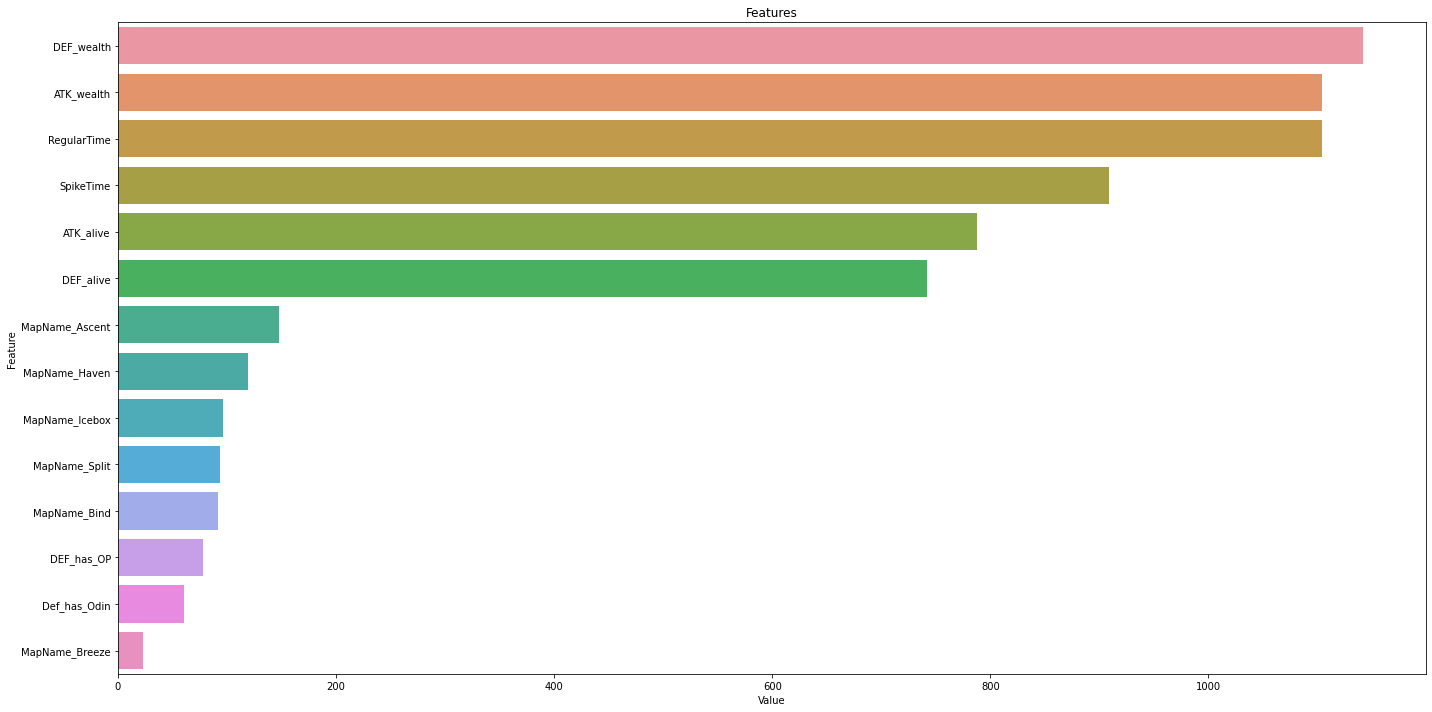

In [16]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Features')
plt.tight_layout()
plt.show()

# <font color='blue'>MODEL PRECISION </font>

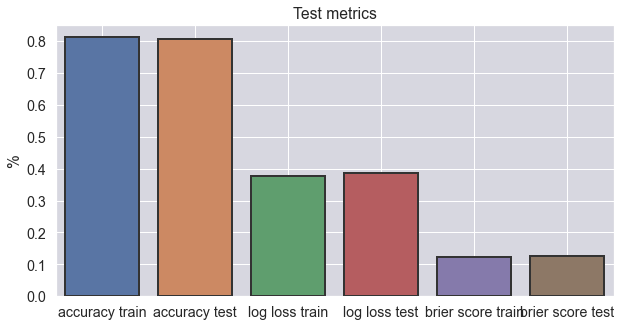

Wall time: 1.13 s


In [17]:
%%time
plt.figure(figsize = (10,5))

pred_proba = model.predict_proba(X_train)
pred_proba_test = model.predict_proba(X_test)

gmt = ["accuracy train", "accuracy test", "log loss train", "log loss test", "brier score train", "brier score test"]
metrics = {'Labels': gmt,
           'Value': [model.score(X_train, Y_train), model.score(X_test, Y_test),
                     log_loss(Y_train, pred_proba),log_loss(Y_test, pred_proba_test),
                     brier_score_loss(Y_train, pd.DataFrame(pred_proba)[1]),brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])]
           }

sns.set_context(rc = {'patch.linewidth': 2.0})
sns.set(font_scale=1.3)
ax = sns.barplot(x='Labels', y='Value', data=metrics, linewidth=2.0, edgecolor=".2", zorder=3, palette=sns.color_palette("deep"))

plt.ylabel('%')
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.grid(linewidth=1, color='white', zorder=0)
ax.set_facecolor("#d7d7e0")
plt.title("Test metrics")
plt.show()

# <font color='blue'>REALIBITY CURVE </font>

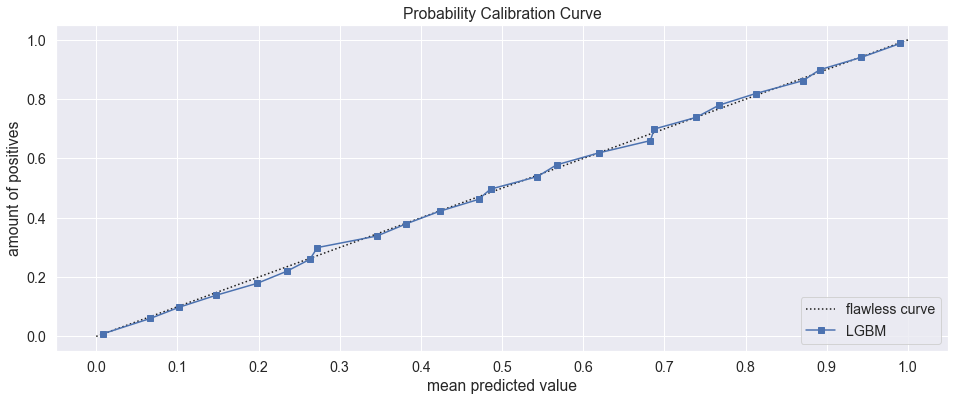

Wall time: 171 ms


Text(0.5, 0, 'mean predicted value')

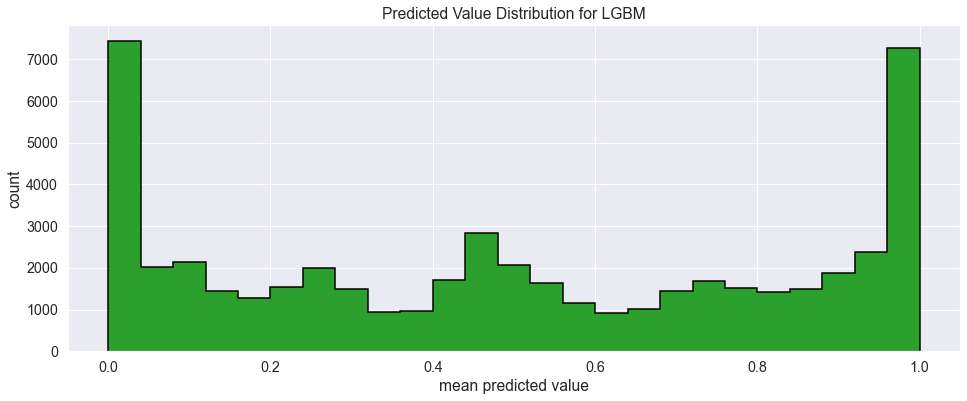

In [19]:
%%time
plt.figure(figsize=(16,6))
plt.plot([0,1], [0,1], 'k:', label='flawless curve')
x, y = calibration_curve(Y_test, pd.DataFrame(pred_proba_test)[1], n_bins=25)
plt.plot(x, y, 's-', label='LGBM')
plt.legend(loc='lower right')
plt.title('Probability Calibration Curve')
plt.ylabel('amount of positives')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

plt.figure(figsize=(16,6))
plt.hist(pd.DataFrame(pred_proba_test)[1], range=(0,1), bins=25, histtype="step", lw=2, fill=True, color='tab:green',
        edgecolor='black', linewidth=1.5)
plt.title('Predicted Value Distribution for LGBM')
plt.ylabel('count')
plt.xlabel('mean predicted value')

# <font color='blue'>CONFUSION MATRIX </font>

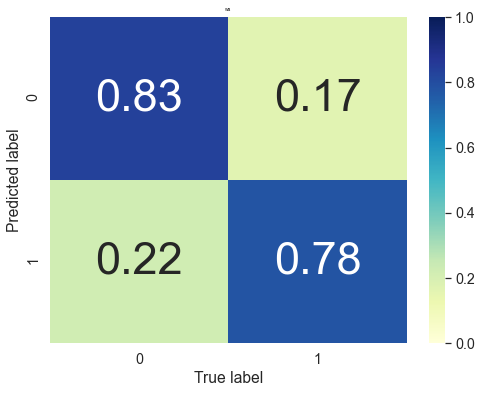

In [20]:
plt.figure(figsize = (8,6))
cm = confusion_matrix(Y_test, model.predict(X_test, num_iteration=50))
cm = (cm/cm.sum(axis=1).reshape(-1,1))

sns.heatmap(cm, cmap="YlGnBu", vmin=0., vmax=1., annot=True, annot_kws={'size':45})
plt.title("wa", fontsize = 5)
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

In [21]:
Y_pred = model.predict(X_test)
classification_report(Y_test, Y_pred, output_dict=True)["weighted avg"]["f1-score"]

0.8072180956749032